In [ ]:
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from PIL import Image
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def generate_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "without_mask":
        return 2
    return 3

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
#         img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["image_id"] = img_id
        return target

class MaskDataset(object):
    def __init__(self, imgs, labels, transforms):
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx):
        # load images ad masks
        img_path = "****/final_final_data/images/"+ self.imgs[idx]
        label_path = "****/final_final_data/annotations/" + self.labels[idx]
        img = Image.open(img_path).convert("RGB") 
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)
    

In [ ]:
base_path = "****/final_final_data/"

In [ ]:
imgs = list(sorted(os.listdir(base_path+"images")))

In [ ]:
labels = list(sorted(os.listdir(base_path + "annotations")))

In [ ]:
from collections import defaultdict

def return_idx(lbl, val_count = 2):
    result = defaultdict(list)
    for idx,lb in enumerate(lbl):
        anp = base_path+"annotations/"+lb
        target = generate_target(anp)
        label = str(list(set(target["labels"].cpu().numpy())))
        
        if label in result:
            if len(result[label]) == val_count and label !='[1]':
                pass
            else:
                result[label].append(idx)
        else:
            result[label].append(idx)
                
    return result

In [ ]:
a = return_idx(labels)

In [ ]:
class_1 = a['[1]'][2:]
sampleList = random.sample(class_1, 500)

In [ ]:
a['[1]'] = a['[1]'][:2]

In [ ]:
val_list = []
for aa in a.values():
    print(aa)
    val_list.extend(aa)

[0, 1]
[2, 3]
[4, 5]
[8, 13]
[47, 73]
[74, 137]
[118, 122]


In [ ]:
val_list

[0, 1, 2, 3, 4, 5, 8, 13, 47, 73, 74, 137, 118, 122]

In [ ]:
len(imgs)

1022

In [ ]:
alls = list(range(0,len(imgs)))
train_list = [x for x in alls if x not in val_list and x not in sampleList]
train_list

[6,
 7,
 9,
 10,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 115,
 116,
 121,
 123,
 125,
 126,
 127,
 128,
 129,
 130,
 132,
 135,
 138,
 144,
 146,
 147,
 151,
 153,
 154,
 156,
 157,
 159,
 162,
 165,
 169,
 174,
 175,
 178,
 180,
 181,
 184,
 185,
 186,
 192,
 193,
 198,
 203,
 204,
 212,
 215,
 216,
 223,
 224,
 225,
 229,
 230,
 231,
 245,
 248,
 249,
 250,
 254,
 258,
 259,
 261,
 262,
 264,
 265,
 266,
 268,
 269,
 273,
 275,
 280,
 283,
 285,
 289,
 292,
 294,
 296,
 303,
 304,
 308,
 310,
 311,
 313,
 315,
 317,
 318,
 321,
 323,
 325,
 327,
 333,
 334,
 335,
 336,
 338,
 339,
 34

In [ ]:
train_transform = transforms.Compose([
        transforms.ToTensor()
    ])
valid_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = MaskDataset([imgs[i] for i in train_list[:971]], [labels[i] for i in train_list],train_transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

valid_dataset = MaskDataset([imgs[i] for i in val_list], [labels[i] for i in val_list],valid_transform)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# test_dataset = MaskDataset(imgs[-5:], labels[-5:],valid_transform)
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
len(train_dataset),len(valid_dataset)

(508, 14)

In [ ]:
torch.cuda.is_available()

True

## Model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [ ]:
model = get_model_instance_segmentation(3)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train model

In [ ]:
img, gt = next(iter(train_data_loader))
annotations = [{k: v.to(device) for k, v in t.items()} for t in gt]
annotations

[{'boxes': tensor([[ 96., 171., 197., 282.]], device='cuda:0'),
  'labels': tensor([2], device='cuda:0')},
 {'boxes': tensor([[328.,  33., 350.,  57.],
          [366.,  70., 384.,  92.],
          [249.,  44., 268.,  63.],
          [278.,  71., 292.,  87.],
          [ 29.,  47.,  46.,  67.],
          [ 37.,  63.,  59.,  88.],
          [179.,  40., 205.,  67.],
          [ 68.,  67.,  90.,  91.],
          [  1.,  46.,  18.,  63.],
          [137.,  57., 155.,  76.],
          [235.,  51., 249.,  67.],
          [282.,  33., 301.,  51.],
          [ 89.,  54., 103.,  71.]], device='cuda:0'),
  'labels': tensor([1, 3, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 2], device='cuda:0')},
 {'boxes': tensor([[ 49., 146., 102., 201.],
          [ 26.,  82.,  70., 122.],
          [ 73.,  48., 102.,  78.],
          [137.,  42., 163.,  74.],
          [187.,  52., 220.,  86.],
          [226.,  47., 248.,  70.],
          [285.,  35., 322.,  71.],
          [363.,  32., 397.,  72.]], device='cuda:0'),
  

In [ ]:
import time
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches

num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.02, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
resume = '*'
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
model_name = "fastrcnn_res50_epoch25"
resume = 'fastrcnn_res50_epoch25.pth'
if os.path.isfile(resume):
      print("=> loading checkpoint '{}'".format(model_name))
      checkpoint = torch.load(resume)
      start_epoch = checkpoint['epoch']
      lr_scheduler.load_state_dict(checkpoint['scheduler'])
      model.load_state_dict(checkpoint['state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer'])
      print("=> loaded checkpoint '{}' (epoch {})" .format(model_name, start_epoch))
else:
      print("=> no checkpoint found at '{}'".format(model_name))

Epoch :1



Epoch train loss is 0.6273703970543043



Epoch valid loss is 0.37696782499551773


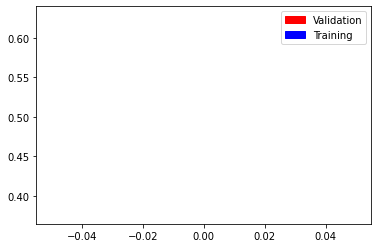

Epoch :2



Epoch train loss is 0.435908051808988



Epoch valid loss is 0.30461468920111656


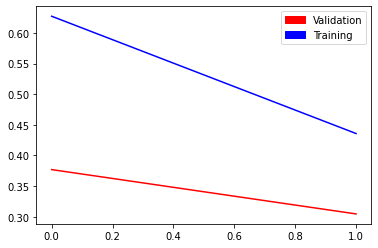

Epoch :3



Epoch train loss is 0.3301612286586461



Epoch valid loss is 0.2784177102148533


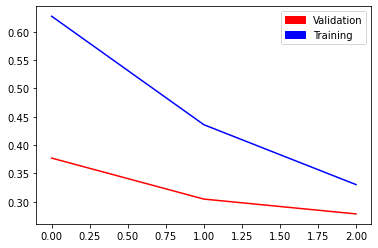

Epoch :4



Epoch train loss is 0.28563162185779706



Epoch valid loss is 0.2661154791712761


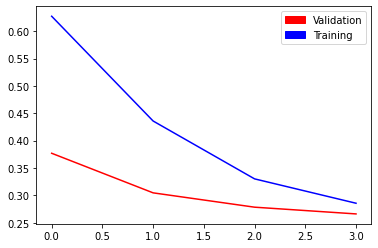

Epoch :5



Epoch train loss is 0.27843268767116575



Epoch valid loss is 0.2574365399777889


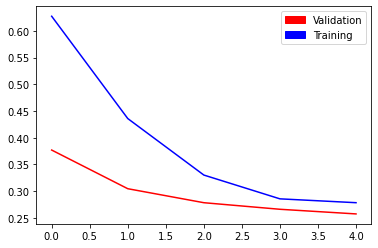

Epoch :6



Epoch train loss is 0.2718909242608416



Epoch valid loss is 0.26165536046028137


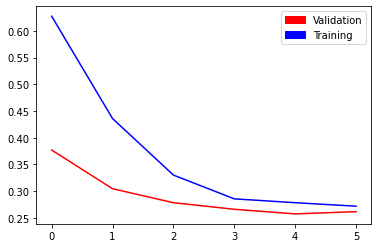

Epoch :7



Epoch train loss is 0.2968357095685531



Epoch valid loss is 0.25793904811143875


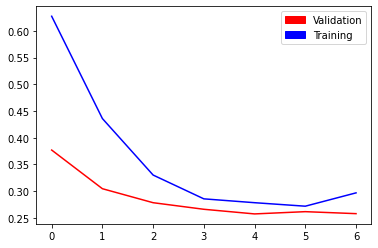

Epoch :8



Epoch train loss is 0.26437593591729486



Epoch valid loss is 0.2521398290991783


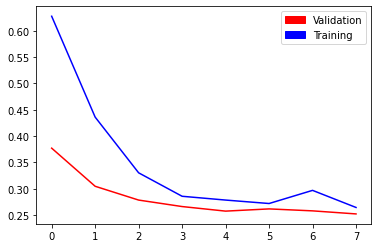

Epoch :9



Epoch train loss is 0.2982886676478574



Epoch valid loss is 0.257373109459877


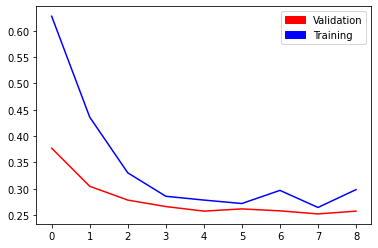

Epoch :10



Epoch train loss is 0.2965634114981636



Epoch valid loss is 0.2484254278242588


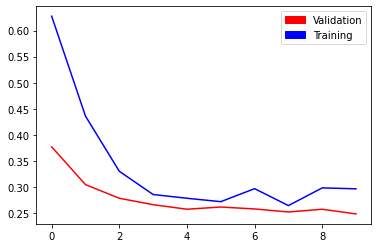

Epoch :11



Epoch train loss is 0.26374929615362425



Epoch valid loss is 0.2515374422073364


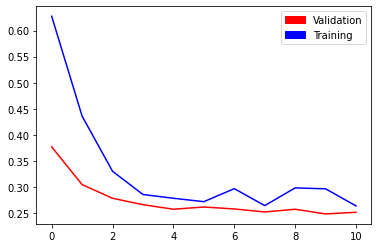

Epoch :12



Epoch train loss is 0.2638799186179957



Epoch valid loss is 0.2533620707690716


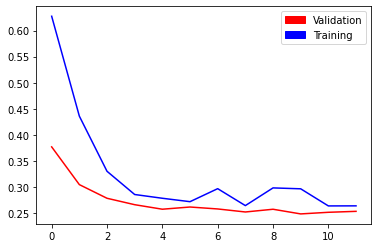

Epoch :13



Epoch train loss is 0.26327503214436254



Epoch valid loss is 0.25656120851635933


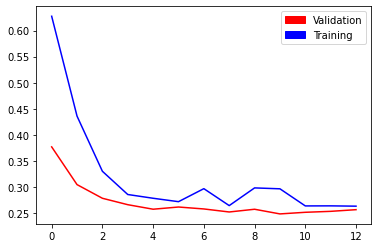

Epoch :14



Epoch train loss is 0.26352196154514634



Epoch valid loss is 0.25777893885970116


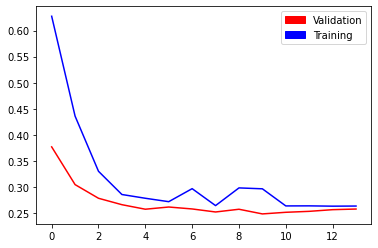

Epoch :15



Epoch train loss is 0.33925797895887705



Epoch valid loss is 0.25241710990667343


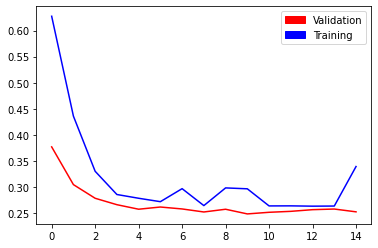

Epoch :16



Epoch train loss is 0.2635602617533658



Epoch valid loss is 0.2551092468202114


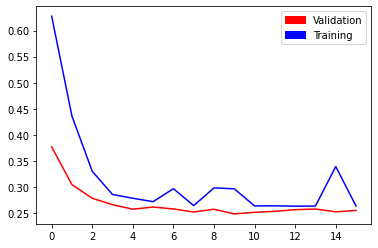

Epoch :17



Epoch train loss is 0.29479869830561434



Epoch valid loss is 0.2517825812101364


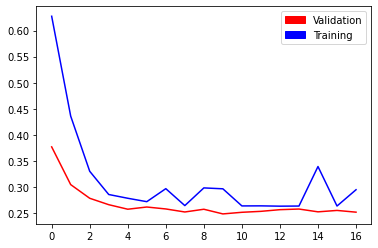

Epoch :18



Epoch train loss is 0.26394195408802335



Epoch valid loss is 0.2541131228208542


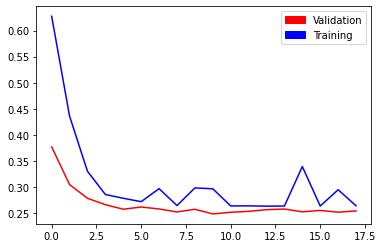

Epoch :19



Epoch train loss is 0.29955098461213076



Epoch valid loss is 0.252521526068449


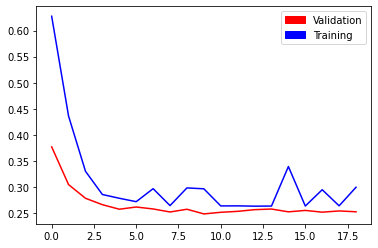

Epoch :20



Epoch train loss is 0.3008699579032387



Epoch valid loss is 0.2540585361421108


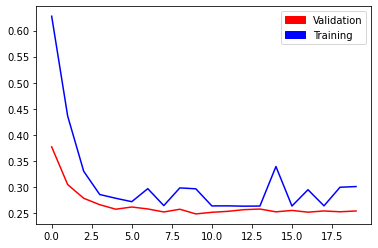

Epoch :21



Epoch train loss is 0.29579425579684926



Epoch valid loss is 0.2519735135138035


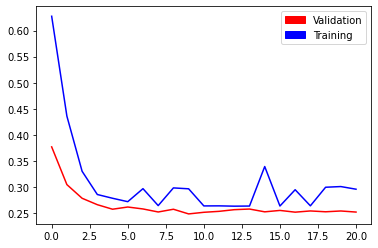

Epoch :22



Epoch train loss is 0.2633898678844369



Epoch valid loss is 0.2535289563238621


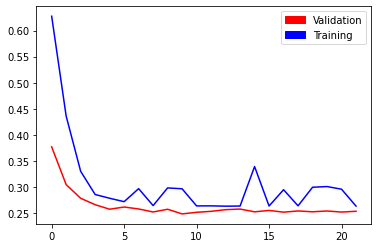

Epoch :23



Epoch train loss is 0.2640165994603803



Epoch valid loss is 0.2547725662589073


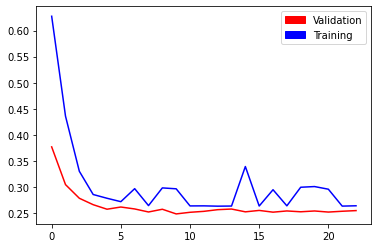

Epoch :24



Epoch train loss is 0.26298817739946634



Epoch valid loss is 0.2549709603190422


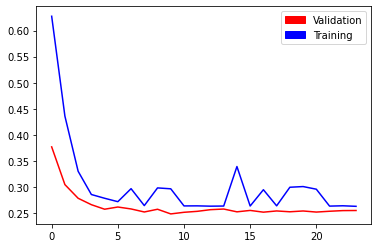

Epoch :25



Epoch train loss is 0.2637321664475081



Epoch valid loss is 0.2584623210132122


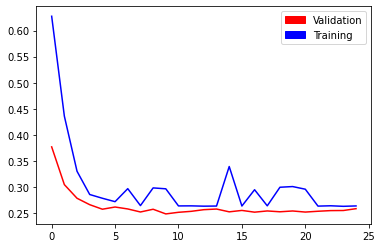

215m 55s


In [ ]:
total_train_loss = []
total_valid_loss = []
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')   
    train_loss = []
    valid_loss = []
    for imgs, annotations in tqdm(train_data_loader):
        model.train()
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        train_loss.append(losses.item()) 
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')

    for imgs, annotations in tqdm(valid_data_loader):
        with torch.no_grad():
          imgs = list(img.to(device) for img in imgs)
          annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
          loss_dict = model(imgs, annotations)
          losses = sum(loss for loss in loss_dict.values())
          valid_loss.append(losses.item()) 

    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)
    print(f'Epoch valid loss is {epoch_valid_loss}')
    lr_scheduler.step()

    plt.plot(range(len(total_train_loss)), total_train_loss, 'b', range(len(total_valid_loss)), total_valid_loss,'r')
    red_patch = mpatches.Patch(color='red', label='Validation')
    blue_patch = mpatches.Patch(color='blue', label='Training')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

time_elapsed = time.time() - start_time
print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
model_name = "fastrcnn_res50_epoch25_50"
filename = f'{model_name}.pth'
state={
      'epoch': num_epochs,
      'state_dict': model.state_dict(),
      'optimizer' : optimizer.state_dict(),
      'scheduler': lr_scheduler.state_dict(),
      }
torch.save(state, filename)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
iterations=2
dataloader_iterator = iter(valid_data_loader)
for i in range(iterations):     
    try:
        imgs, annotations = next(dataloader_iterator)
    except:
        dataloader_iterator = iter(valid_data_loader)
        imgs, annotations = next(dataloader_iterator)
imgs = list(img.to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

In [ ]:
imgs[0].

In [ ]:
model.eval()
preds = model(imgs)
preds

In [ ]:
imgs[1].shape

## Plot image

In [ ]:
def plot_image(img_tensor, annotation, mode = "pred"):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    if mode=="pred":
        mask=annotation["scores"]>0.5
    else:
        mask=annotation["labels"]>0
        
    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for (box,label) in zip(annotation["boxes"][mask],annotation["labels"][mask]):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        if label==1:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            print("with_mask")
        elif label==2:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            print("without_mask")
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            print("mask_weared_incorrect")

        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis("off")
    plt.show()

In [ ]:
n = 0
print("Prediction")
plot_image(imgs[n], preds[n])
print("Target")
plot_image(imgs[n], annotations[n], mode="target")

## For testset

In [ ]:
iterations=2
dataloader_iterator = iter(test_data_loader)
for i in range(iterations):     
    try:
        imgs, annotations = next(dataloader_iterator)
    except:
        dataloader_iterator = iter(test_data_loader)
        imgs, annotations = next(dataloader_iterator)
imgs = list(img.to(device) for img in imgs)
annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

In [ ]:
imgs[0].shape

In [ ]:
a = imgs[0].cpu().numpy()
b = np.transpose(a,(1,2,0))
plt.imshow(b)

In [ ]:
model.eval()
preds = model(list(imgs[0][None, :, :]))
preds

In [ ]:
n = 0
print("Prediction")
plot_image(imgs[n], preds[n])
print("Target")
plot_image(imgs[n], annotations[n], mode="target")

In [ ]:
import PIL.Image as pilimg

In [ ]:
plt.imshow(a)

In [ ]:
a = pilimg.open('*.png').convert("RGB")
b = valid_transform(a)
b = b.to(device)

